# Approach 1: difference between frames
Based on code created by Rune, available on <br>
https://www.learnpythonwithrune.org/opencv-counting-cars-a-simple-approach/

In [12]:
import cv2
import imutils
import threading
import numpy as np
import matplotlib.pyplot as plt
import time

# Play video

In [93]:
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('videos/13_de_maio.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False): 
      print("Error opening video stream or file")

# # Read until video is completed
frames = []
while(cap.isOpened()):
  # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        frames.append(frame)
            
        # Display the resulting frame
        cv2.imshow('Frame',frame)
        
        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

  # Break the loop
    else: 
        break

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()

# Difference between frames

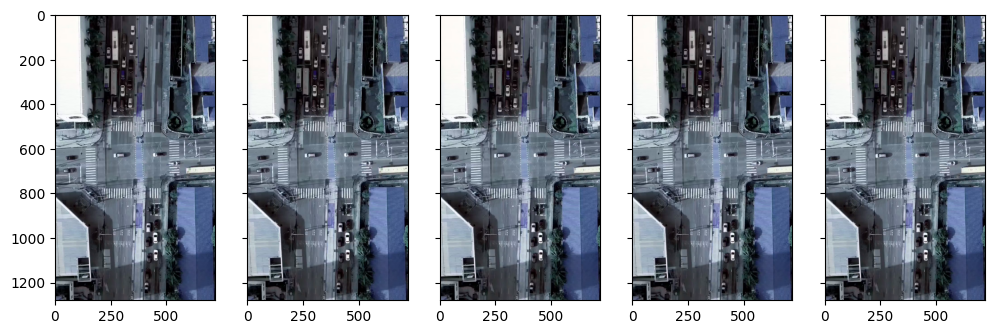

In [94]:
fig, ax = plt.subplots(1, 5, figsize=(12, 4), dpi = 100, sharey=True)
for i in range(5):
    ax[i].imshow(frames[i])


## Grayscale and gaussian blur

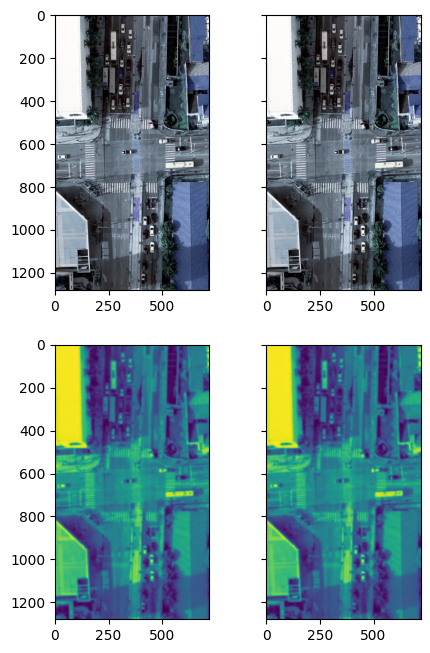

In [95]:
fig, ax = plt.subplots(2, 2, figsize=(5, 8), dpi = 100, sharey=True)
ix = 100
ix_last = ix-1
frame = frames[ix]
last_frame = frames[ix_last]
# initial
ax[0,0].imshow(frame)
ax[0,1].imshow(last_frame)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
# We blur it to minimize reaction to small details
gray = cv2.GaussianBlur(gray, (21, 21), 0)

last_gray = cv2.cvtColor(last_frame, cv2.COLOR_BGR2GRAY)
# We blur it to minimize reaction to small details
last_gray = cv2.GaussianBlur(last_gray, (21, 21), 0)

ax[1,0].imshow(gray)
ax[1,1].imshow(last_gray)

## Thresholding the difference between frames

box 0 area: 1863.5
box 1 area: 2598.5
box 2 area: 1699.5
box 3 area: 4068.0
box 4 area: 4372.0
box 5 area: 8892.0
box 6 area: 2665.0


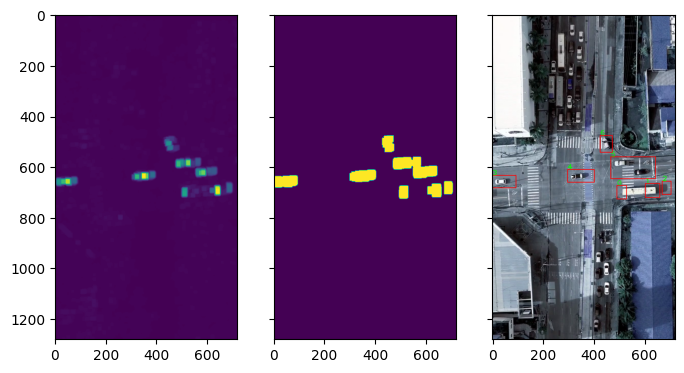

In [96]:
fig, ax = plt.subplots(1, 3, figsize=(8, 12), dpi = 100, sharey=True)

# Get the difference from last_frame
delta_frame = cv2.absdiff(last_gray, gray)
delta_frame = cv2.dilate(delta_frame, None, iterations=6)
ax[0].imshow(delta_frame)

# Have some threshold on what is enough movement
thresh = cv2.threshold(delta_frame, 20, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.dilate(thresh, None, iterations=6)
ax[1].imshow(thresh)

# Returns a list of objects
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Converts it
contours = imutils.grab_contours(contours)
# Loops over all objects found
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    print('box ' + str(i) + ' area: ' + str(area))
    # Get's a bounding box and puts it on the frame
    (x, y, w, h) = cv2.boundingRect(contour)
    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
    if area > 100:
        text = str(i) + ' vehicle'
    else:
        text = str(i) + ' pedestrian'
    cv2.putText(frame, str(i), (x, y), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    
ax[2].imshow(frame)

In [8]:
frame.shape

(1280, 720, 3)

# Counting objects that pass through boxes

In [105]:
def grayscale_blur(img):
    # Processing of frames are done in gray    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # We blur it to minimize reaction to small details
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    return gray

def difference(gray, last_gray):
    # Get the difference from last_frame
    delta_frame = cv2.absdiff(last_gray, gray)
    delta_frame = cv2.dilate(delta_frame, None, iterations=6)
    return delta_frame

def thresholding_countours(delta_frame, threshold_value, iterations_dilatation = 4):
    thresh = cv2.threshold(delta_frame, threshold_value, 255, cv2.THRESH_BINARY)[1]
    # This dilates with two iterations
    #thresh = cv2.dilate(thresh, None, iterations=iterations_dilatation)
    # Returns a list of objects
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Converts it
    contours = imutils.grab_contours(contours)
    return thresh, contours
    

In [106]:
class Box:
    def __init__(self, start_point, width_height):
        self.start_point = start_point
        self.end_point = (start_point[0] + width_height[0], start_point[1] + width_height[1])
        self.counter = 0
        self.frame_countdown = 0
    def overlap(self, start_point, end_point):
        if self.start_point[0] >= end_point[0] or self.end_point[0] <= start_point[0] or \
                self.start_point[1] >= end_point[1] or self.end_point[1] <= start_point[1]:
            return False
        else:
            return True

In [112]:
# configurable parameters

box_width = 5
# The boxes we want to count moving objects in
boxes = []
# horizontal
boxes.append(Box((0, 0), (frame.shape[1], box_width)))
# vertical
boxes.append(Box((0, 0), (box_width, frame.shape[0])))
pos = ['horizontal', 'vertical']

threshold_value = 30
minimal_countour_area = 50
minimum_vehicle_area = 200
iterations_dilatation = 6

In [118]:
(int(frame.shape[1]/2), int(frame.shape[0]/2))

(360, 640)

In [120]:
cap = cv2.VideoCapture('videos/13_de_maio.mp4')

# We will keep the last frame in order to see if there has been any movement
last_frame = None
# To build a text string with counting status
text = ""


pedestrians = 0
vehicles = 0
out = cv2.VideoWriter('output.avi', -1, 20.0, (360, 640))

while cap.isOpened():
    #time.sleep(0.5)
    ret, frame = cap.read()
    if not ret:
        break
    
    gray =  grayscale_blur(frame)
    
    # Need to check if we have a last_frame, if not get it
    if last_frame is None or last_frame.shape != gray.shape:
        last_frame = gray
        continue
    
    delta_frame = difference(gray, last_frame)
    last_frame = gray    
    thresh, contours = thresholding_countours(delta_frame, threshold_value, iterations_dilatation)    
    
    # Loops over all objects found
    
    for contour in contours:
        # Skip if contour is small (can be adjusted)
        if cv2.contourArea(contour) < minimal_countour_area:
            continue
        if cv2.contourArea(contour) > 100:
            object_type = 'car'
        else:
            object_type = 'pedestrian'
            
        # Get's a bounding box and puts it on the frame
        (x, y, w, h) = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # The text string we will build up
        text = "box: "
        # Go through all the boxes
        for box, p in zip(boxes, pos):
            box.frame_countdown -= 1
            if box.overlap((x, y), (x + w, y + h)):
                if box.frame_countdown <= 0:
                    if object_type == 'pedestrian':
                        pedestrians += 1
                    else:
                        vehicles += 1
                        
                    box.counter += 1
                # The number might be adjusted, it is just set based on my settings
                box.frame_countdown = 20
            text += p + " (" + str(box.counter) + " ," + str(box.frame_countdown) + ") "
    
    # Set the text string we build up
    cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    cv2.putText(frame, "pedestrians: " + str(pedestrians), (10, 75), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    cv2.putText(frame, "vehicles: " + str(vehicles), (10, 95), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    # Let's also insert the boxes
    for box in boxes:
        cv2.rectangle(frame, box.start_point, box.end_point, (255, 255, 255), 2)
    # Let's show the frame in our window
    
    resized = cv2.resize(frame, (int(frame.shape[1]/2), int(frame.shape[0]/2)))
    cv2.imshow("Car counter", resized)
    out.write(resized)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()

In [121]:
print('pedestrians',int(pedestrians))
print('vehicles',int(vehicles))

pedestrians 39
vehicles 664


# Recognize each object

In [ ]:
class Moving_Object:
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.width = w
        self.height = h
        self.frames_off = 0
        
    

In [ ]:
cap = cv2.VideoCapture('videos/13_de_maio.mp4')

# We will keep the last frame in order to see if there has been any movement
last_frame = None
# To build a text string with counting status
text = ""


pedestrians = 0
vehicles = 0
out = cv2.VideoWriter('output.avi', -1, 20.0, (360, 640))

while cap.isOpened():
    #time.sleep(0.5)
    ret, frame = cap.read()
    if not ret:
        break
    
    gray =  grayscale_blur(frame)
    
    # Need to check if we have a last_frame, if not get it
    if last_frame is None or last_frame.shape != gray.shape:
        last_frame = gray
        continue
    
    delta_frame = difference(gray, last_frame)
    last_frame = gray    
    thresh, contours = thresholding_countours(delta_frame, threshold_value, iterations_dilatation)    
    
    # Loops over all objects found
    
    for contour in contours:
        # Skip if contour is small (can be adjusted)
        if cv2.contourArea(contour) < minimal_countour_area:
            continue
        if cv2.contourArea(contour) > 100:
            object_type = 'car'
        else:
            object_type = 'pedestrian'
            
        # Get's a bounding box and puts it on the frame
        (x, y, w, h) = cv2.boundingRect(contour)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # The text string we will build up
        text = "box: "
        # Go through all the boxes
        for box, p in zip(boxes, pos):
            box.frame_countdown -= 1
            if box.overlap((x, y), (x + w, y + h)):
                if box.frame_countdown <= 0:
                    if object_type == 'pedestrian':
                        pedestrians += 1
                    else:
                        vehicles += 1
                        
                    box.counter += 1
                # The number might be adjusted, it is just set based on my settings
                box.frame_countdown = 20
            text += p + " (" + str(box.counter) + " ," + str(box.frame_countdown) + ") "
    
    # Set the text string we build up
    cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    cv2.putText(frame, "pedestrians: " + str(pedestrians), (10, 75), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    cv2.putText(frame, "vehicles: " + str(vehicles), (10, 95), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)
    # Let's also insert the boxes
    for box in boxes:
        cv2.rectangle(frame, box.start_point, box.end_point, (255, 255, 255), 2)
    # Let's show the frame in our window
    
    resized = cv2.resize(frame, (int(frame.shape[1]/2), int(frame.shape[0]/2)))
    cv2.imshow("Car counter", resized)
    #out.write(resized)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
out.release()
cv2.destroyAllWindows()